In [1]:
# Qiskit imports
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit IBM Provider
from qiskit_ibm_provider import IBMProvider, least_busy

import warnings
warnings.filterwarnings("ignore")

In [2]:
provider = IBMProvider()
backend = least_busy(provider.backends(simulator=False, operational=True))
backend

<IBMBackend('ibm_kyoto')>

In [3]:
qreg_data = QuantumRegister(3)
qreg_measure = QuantumRegister(2)
creg_data = ClassicalRegister(3)
creg_syndrome = ClassicalRegister(2)
state_data = qreg_data[0]
ancillas_data = qreg_data[1:]

def build_qc():
    """Build a typical error correction circuit"""
    return QuantumCircuit(qreg_data, qreg_measure, creg_data, creg_syndrome)

def initialize_qubits(circuit: QuantumCircuit):
    """Initialize qubit to |1>"""
    circuit.x(qreg_data[0])
    circuit.barrier(qreg_data)
    return circuit

def encode_bit_flip(circuit, state, ancillas) -> QuantumCircuit:
    """Encode bit-flip. This is done by simply adding a cx"""
    for ancilla in ancillas:
        circuit.cx(state, ancilla)
    circuit.barrier(state, *ancillas)
    return circuit

def measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_measure):
    """
        Measure the syndrome by measuring the parity. 
        We reset our ancilla qubits after measuring the stabilizer
        so we can reuse them for repeated stabilizer measurements. 
        Because we have already observed the state of the qubit, 
        we can write the conditional reset protocol directly to 
        avoid another round of qubit measurement if we used 
        the `reset` instruction.
    """ 
    circuit.cx(qreg_data[0], qreg_measure[0])
    circuit.cx(qreg_data[1], qreg_measure[0])
    circuit.cx(qreg_data[0], qreg_measure[1])
    circuit.cx(qreg_data[2], qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    circuit.measure(qreg_measure, creg_measure)
    with circuit.if_test((creg_syndrome[0], 1)):
        circuit.x(qreg_measure[0])
    with circuit.if_test((creg_syndrome[1], 1)):
        circuit.x(qreg_measure[1])
    circuit.barrier(*qreg_data, *qreg_measure)
    return circuit

def apply_correction_bit(circuit, qreg_data, creg_syndrome):
    """We can detect where an error occurred and correct our state"""
    with circuit.if_test((creg_syndrome, 3)):
        circuit.x(qreg_data[0])
    with circuit.if_test((creg_syndrome, 1)):
        circuit.x(qreg_data[1])
    with circuit.if_test((creg_syndrome, 2)):
        circuit.x(qreg_data[2])
    circuit.barrier(qreg_data)
    return circuit

def apply_final_readout(circuit, qreg_data, creg_data):
    """Read out the final measurements"""
    circuit.barrier(qreg_data)
    circuit.measure(qreg_data, creg_data)
    return circuit

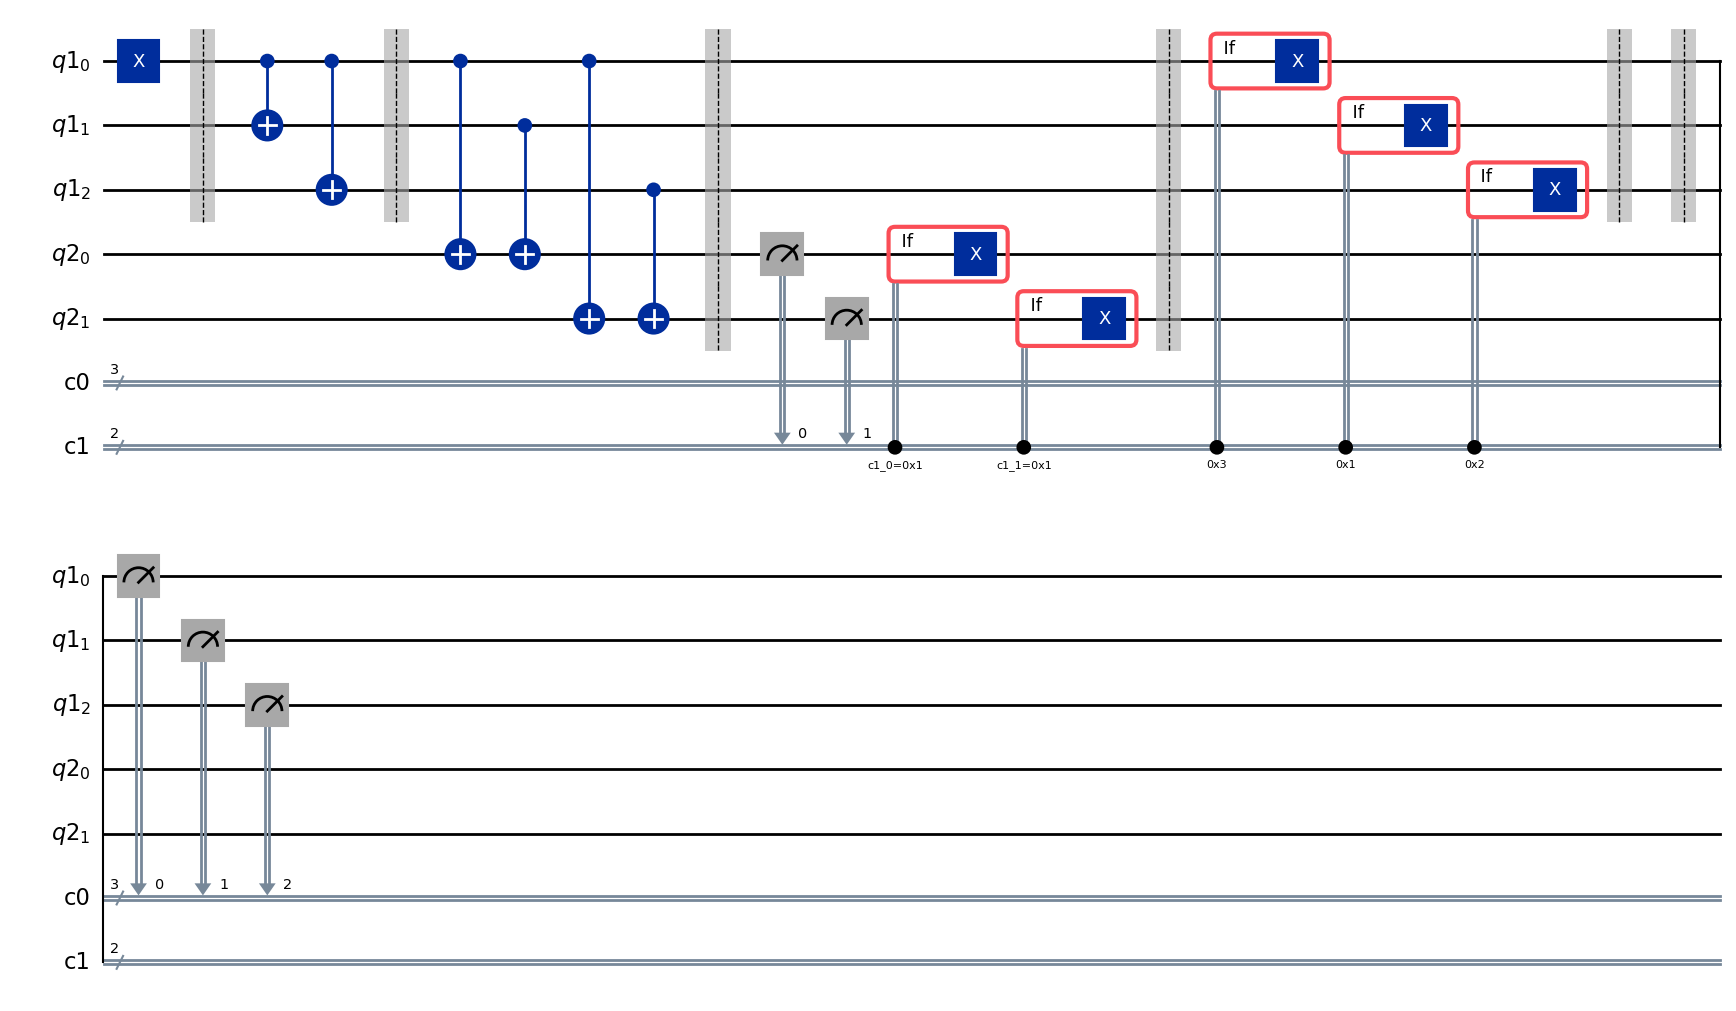

In [4]:
# O código requer cinco qubits: três são usados para codificar o estado protegido e os dois restantes são usados como auxiliares de medição do estabilizador.

def build_error_correction_sequence(apply_correction: bool) -> QuantumCircuit:

    circuit = build_qc()
    circuit = initialize_qubits(circuit)
    circuit = encode_bit_flip(circuit, state_data, ancillas_data)
    circuit = measure_syndrome_bit(circuit, qreg_data, qreg_measure, creg_syndrome)
    
    if apply_correction:
        circuit = apply_correction_bit(circuit, qreg_data, creg_syndrome)
    
    circuit = apply_final_readout(circuit,  qreg_data, creg_data)
    return circuit

circuit = build_error_correction_sequence(apply_correction=True)
circuit.draw(output="mpl", style='iqp')

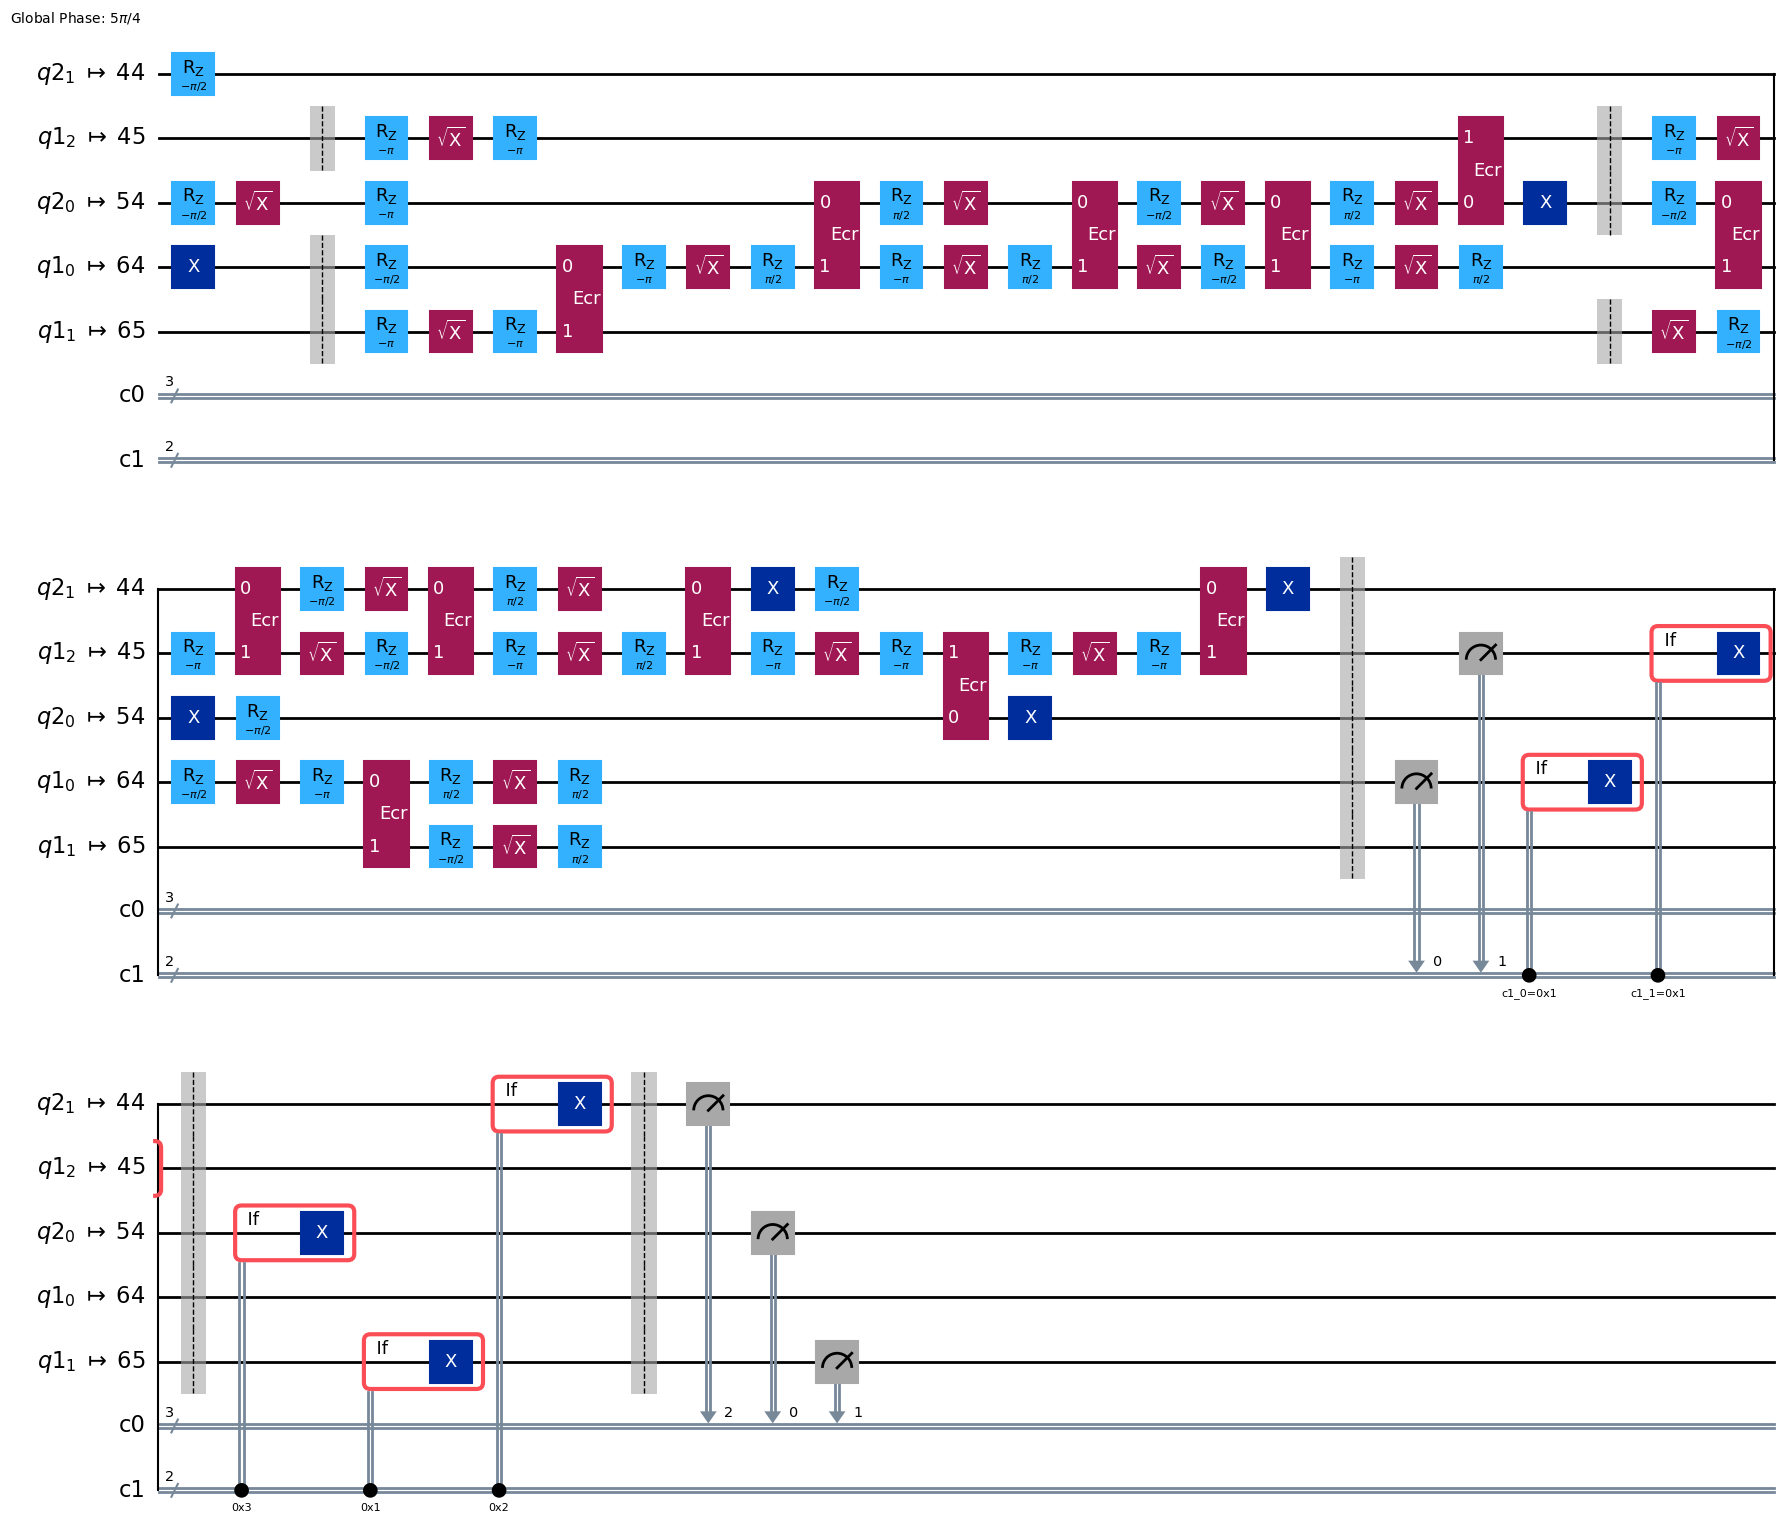

In [5]:
#Vamos transpilar o circuito para selecionar o melhor layout de qubit e roteamento.
transpiled_circuit = transpile(circuit, backend)
transpiled_circuit.draw(output="mpl", style='iqp', idle_wires=False)

In [6]:
no_correction_circuit = build_error_correction_sequence(apply_correction=False)
transpiled_no_correction_circuit = transpile(no_correction_circuit, backend)

In [7]:
job_no_correction = backend.run(transpiled_no_correction_circuit, shots=1000, dynamic=True)
result_no_correction = job_no_correction.result()

In [8]:
job_with_correction = backend.run(transpiled_circuit, shots=1000, dynamic=True)
result_with_correction = job_with_correction.result()

In [9]:
data_indices = list(range(len(qreg_data)))
syndrome_indices = list(range(data_indices[-1] + 1, len(qreg_data) + len(qreg_measure)))

def decode_result(data_counts, syndrome_counts):
    shots = sum(data_counts.values())
    success_trials = data_counts.get('000', 0) + data_counts.get('111', 0)
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get('00', 0)
    print(f"Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials")
    print(f"A final parity error was detected on {failed_trials}/{shots} trials")

In [10]:
non_corrected_marginalized_data_result = marginal_counts(result_no_correction, data_indices)
non_corrected_marginalized_syndrome_result = marginal_counts(result_no_correction, syndrome_indices)

print(f'Completed bit code experiment data measurement counts {non_corrected_marginalized_data_result.get_counts(0)}')
print(f'Completed bit code experiment syndrome measurement counts {non_corrected_marginalized_syndrome_result.get_counts(0)}')
decode_result(non_corrected_marginalized_data_result.get_counts(0), non_corrected_marginalized_syndrome_result.get_counts(0))

Completed bit code experiment data measurement counts {'000': 6, '001': 14, '111': 426, '011': 514, '101': 11, '110': 15, '010': 12, '100': 2}
Completed bit code experiment syndrome measurement counts {'00': 434, '10': 531, '11': 17, '01': 18}
Bit flip errors were detected/corrected on 566/1000 trials
A final parity error was detected on 568/1000 trials


In [11]:
corrected_marginalized_data_result = marginal_counts(result_with_correction, data_indices)
corrected_marginalized_syndrome_result = marginal_counts(result_with_correction, syndrome_indices)

print(f'Completed bit code experiment data measurement counts {corrected_marginalized_data_result.get_counts(0)}')
print(f'Completed bit code experiment syndrome measurement counts {corrected_marginalized_syndrome_result.get_counts(0)}')
decode_result(corrected_marginalized_data_result.get_counts(0), corrected_marginalized_syndrome_result.get_counts(0))

Completed bit code experiment data measurement counts {'001': 12, '111': 433, '110': 17, '010': 21, '101': 469, '011': 12, '000': 27, '100': 9}
Completed bit code experiment syndrome measurement counts {'10': 15, '00': 394, '11': 19, '01': 572}
Bit flip errors were detected/corrected on 606/1000 trials
A final parity error was detected on 540/1000 trials
